In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 11 14:40:27 2020
@author: revan
"""

#linear algebra
import numpy as np 

#data processing
import pandas as pd 
pd.set_option('display.max_columns', 25)

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

#for normalizing data
from sklearn.preprocessing import MinMaxScaler

#For Statistics
from sklearn.metrics import r2_score

#avoid warnings
import warnings
warnings.filterwarnings('ignore')

#to create nueral network
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#setting the seed
import random
np.random.seed(1234)
import tensorflow as tf
tf.random.set_seed(1000)



2024-04-01 19:46:18.403316: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 19:46:19.188902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


DADOS BINANCE

In [2]:
from binance.client import Client

api_key = 'e8n0UyRWAT0mp2tk4XPxQ4ARjsDVfBodiPqa2g4QAw6IL4KBEHznNOTExZimDDvZ'
api_secret = 'BQkCyvFh5Y2feKSiugiA8hqw4sNTdPUK3BFmzNKh70jt3AleAAzz4UZGF8yvzTWf'
symbol = 'BTCUSDT'
interval = '1d'

# Defina as datas de início e término
start_date = '2021-03-01'
end_date = '2023-10-31'

# Converta as datas para timestamps em milissegundos corretamente
start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

client = Client(api_key, api_secret)

# Inicialize uma lista para armazenar os dados
all_klines = []

# Número máximo de candles por solicitação (limitação da API Binance)
limit = 1000

# Faça chamadas repetidas para obter todos os dados
while True:
    # Obtenha o histórico de preços (candles) para o par de negociação e intervalo especificados
    klines = client.get_klines(symbol=symbol, interval=interval, startTime=start_timestamp, endTime=end_timestamp, limit=limit)

    # Adicione os dados à lista
    all_klines.extend(klines)

    # Se o número de candles retornados for menor que o limite, terminamos
    if len(klines) < limit:
        break

    # Atualize a data de início para a próxima chamada
    start_timestamp = int(klines[-1][0]) + 1

# Estrutura dos dados para DataFrame
columns = ['Date', 'Open', 'high', 'low', 'Close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
df1 = pd.DataFrame(all_klines, columns=columns)
#df1.drop(columns=['close_time', 'quote_asset_volume','number_of_trades','taker_buy_base_asset_volume','taker_buy_quote_asset_volume','ignore'], inplace=True)
# Converta os timestamps para formato legível
df1['Date'] = pd.to_datetime(df1['Date'], unit='ms')
df1.set_index('Date', inplace=True)
df1.to_csv('dadosBinance.csv', index=True)

# Calcular o tamanho do conjunto de treinamento
train_size = int(0.8 * len(df1))
# Dividir o DataFrame em treinamento e teste
train_data = df1.iloc[:train_size]
test_data = df1.iloc[train_size:]
# Salvar os dados de treinamento em um arquivo CSV
train_data.to_csv('dados_treinamento.csv', index=True)
# Salvar os dados de teste em um arquivo CSV
test_data.to_csv('dados_teste.csv', index=True)

# DataFrame com os dados
print(df1)

                      Open            high             low           Close  \
Date                                                                         
2021-03-01  45134.11000000  49790.00000000  44950.53000000  49587.03000000   
2021-03-02  49595.76000000  50200.00000000  47047.60000000  48440.65000000   
2021-03-03  48436.61000000  52640.00000000  48100.71000000  50349.37000000   
2021-03-04  50349.37000000  51773.88000000  47500.00000000  48374.09000000   
2021-03-05  48374.09000000  49448.93000000  46300.00000000  48751.71000000   
...                    ...             ...             ...             ...   
2023-10-27  34151.66000000  34245.00000000  33390.95000000  33892.02000000   
2023-10-28  33892.01000000  34493.33000000  33860.00000000  34081.00000000   
2023-10-29  34081.01000000  34750.11000000  33930.00000000  34525.89000000   
2023-10-30  34525.88000000  34856.00000000  34062.84000000  34474.73000000   
2023-10-31  34474.74000000  34720.49000000  34025.00000000  3463

2024-04-01 19:49:59.391249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 19:49:59.391473: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


ValueError: Input 0 of layer "lstm_2" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)

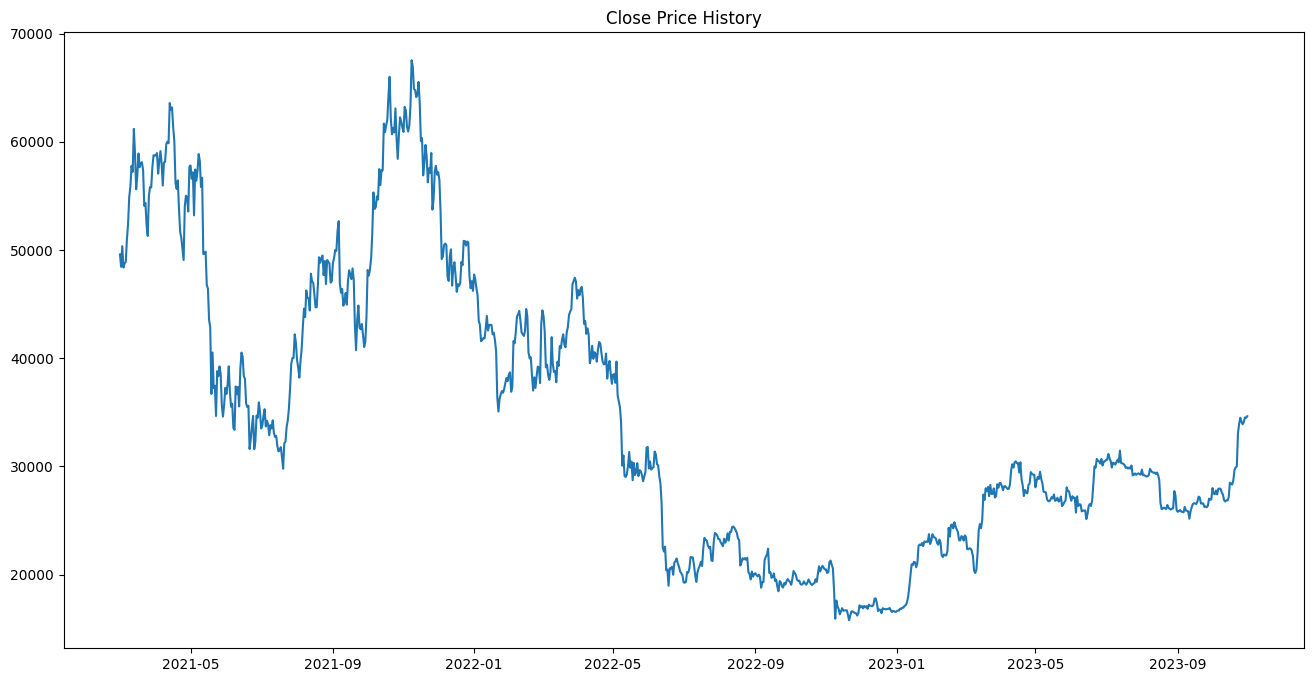

In [3]:
def build_model(train,valid,new_data,scaler,params,
                scaled_data_train,scaled_data_valid):    
    
    #creating the training set in the required format
    #we will put together 60 days (offset) of data together and treat that as single input 
    #and the target value is the 'Close' price on the next day
    x_train, y_train = [], []
    for i in range(params['offset'],len(train)):
        arg1 = scaled_data_train[i-params['offset']:i,0]
        arg2 = scaled_data_train[i-params['offset']:i,1]
        arg  = [arg1, arg2]
        x_train.append(arg)
        y_train.append(scaled_data_train[i,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[2],x_train.shape[1]))
    
    #creating a new dataframe which will be used to create the test set
    inputs = new_data[len(new_data) - len(valid) - params['offset']:].values
    #inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)
    
    X_test, Y_test = [], []
    for i in range(params['offset'],inputs.shape[0]):
        arg1 = inputs[i-params['offset']:i,0]
        arg2 = inputs[i-params['offset']:i,1]
        arg  = [arg1, arg2]
        X_test.append(arg)
        Y_test.append(inputs[i,0])
        
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[2],X_test.shape[1]))    
    
    #create and fit the LSTM network
    #we are building a general model here. This section of code will be used in further steps
    #where we will check if only 1 hidden layer can give better results
    #so an if-else loop is created to combat that situaiton
    if params['units_2'] != 0:
        
        model = Sequential()
        model.add(LSTM(units=params['units_1'], return_sequences=True, 
                       input_shape=(x_train.shape[1],2)))
        model.add(Dropout(rate=params['drop_rate_1']))
        model.add(LSTM(units=params['units_2'], return_sequences=True))
        model.add(Dropout(rate=params['drop_rate_2']))
        model.add(LSTM(units=params['units_3'])) #----------New
        model.add(Dropout(rate=params['drop_rate_3'])) #--------New
        model.add(Dense(params['no_of_outputs'])) 
        
    else:
        
        model = Sequential()
        model.add(LSTM(units=params['units_1'], return_sequences=False, 
                       input_shape=(x_train.shape[1],2)))
        model.add(Dropout(rate=params['drop_rate_1']))
        model.add(Dense(params['no_of_outputs']))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(x_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        verbose=1, validation_data=[X_test, Y_test])
    
    return model, history, X_test

def get_accuracy(train,valid,new_data,tl, 
                 scaler,model,X_test):
    
    closing_price = model.predict(X_test)
    
    #when the previous 'scaler' was created, it was created on dataframe and there are 2 columns
    #in the dataframe and there will be seperate scale for each column
    #Here when applying the inverse scaler transform, we need to apply on only 'Close' price column
    #So creating a 'new_scaler' but setting the scale values of the original scaler here
    #The index of scaler attribute coorresponds to column no. of the required column
    new_scaler = MinMaxScaler(feature_range=(0, 1))
    new_scaler.min_ , new_scaler.scale_ = scaler.min_[1], scaler.scale_[1]
    
    closing_price = new_scaler.inverse_transform(closing_price)
    
    train = new_data[:tl]
    valid = new_data[tl:]
    valid['Predictions'] = closing_price
    
    #for plotting
    plt.figure(figsize=(16,8))
    plt.plot(train['Close'])
    plt.plot(valid['Close'], label='Actual Close Price')
    plt.plot(valid['Predictions'] , label='Predicted Close Price')
    plt.legend()
    plt.savefig('Predicted-Close.png')
    
    #RMS error
    rms = np.sqrt(np.mean(np.power((valid-closing_price),2)))
    
    #R-squared
    y_true = valid['Close']
    y_pred = valid['Predictions']
    r = r2_score(y_true, y_pred)
    
    return rms, r  
   
def run(data_df, params):    
    
    #Plot the data and check if there are any unexpected anamolies(sudden spikes or dips)
    plt.figure(figsize=(16,8))
    plt.plot(data_df['Close'], label='Close Price history')
    plt.title('Close Price History')
    
    #In our model, we will try to predict the future close price of a stock using the past
    #open and close prices of that particular stock. So let's a create a new dataframe with 
    #only the 'Date', 'Open' and 'Close' price columns
    new_data = pd.DataFrame(index=range(0,len(data_df)),columns=['Date', 'Open', 'Close', 'volume'])
    for i in range(0,len(data_df)):
        new_data['Date'][i]  = data_df.index[i]
        new_data['Open'][i]  = data_df['Open'][i]
        new_data['Close'][i] = data_df['Close'][i]
        new_data['volume'][i] = data_df['volume'][i]
        
    #setting 'Date' column as index and dropping the original column
    new_data.index = new_data.Date
    new_data.drop('Date', axis=1, inplace=True)
    
    #80% of the data is used as training set and 20% as test set
    #'test set' here is referred to as 'validatation set'
    frac = 0.8
    tl = int(len(new_data)*frac)
    
    dataset = new_data.values
    train = dataset[0:tl,:]
    valid = dataset[tl:,:]
    
    #Normalizing the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(train)
    scaled_data_train = scaler.transform(train)
    scaled_data_valid = scaler.transform(valid)
    
    #building the LSTM model
    model, history, X_test = build_model(train,valid,new_data,scaler,params,
                                         scaled_data_train,scaled_data_valid)
    
    #getting the 'RMSE error' and 'R-squared value'
    rms, r = get_accuracy(train,valid,new_data,tl,
                          scaler,model,X_test)
    
    #Conveting the params in dictionary to dataframe, to store all the data
    params_items = params.items()
    params_list  = list(params_items)    
    params_df = pd.DataFrame(params_list, index=params.keys())
    
    #Adding errors to the above dataframe    
    errors = {'RMS': rms,
              'R-square':r}
    errors_items = errors.items()
    errors_list  = list(errors_items)    
    errors_df = pd.DataFrame(errors_list, index=errors.keys())
    
    result_df = pd.concat([params_df,errors_df])
    result_df = result_df.drop([0], axis=1)
    
    return result_df


if __name__ == '__main__':
    
    #Readind the data and changing it into pandas dataframe
    data_df = pd.read_csv('dadosBinance.csv', index_col='Date', parse_dates=True)
    
    #Defining the initial parameters of the model    
    params = {'offset':60,
              'units_1':32,
              'drop_rate_1':0,
              'units_2':32,
              'drop_rate_2':0,
              'units_3':32,
              'drop_rate_3':0,
              'batch_size':5,
              'epochs':10,
              'no_of_outputs':1}    

    result_df = run(data_df, params)
    
    #Printing the params and errors
    print(result_df)